In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ortho_group

In [22]:
def tensor2(a,b):
    return np.tensordot(a,b, axes=0)

def tensor3(a, b, c):
    return np.tensordot(np.tensordot(a,b,axes=0), c, axes=0)

def uniformSphere(d, m_x):
    x = np.random.normal(size=(m_x,d))
    for i in range(m_x):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x
def test(a,x,f):
    return f(np.dot(a,x))

def g(x):
    return 1/(1+np.exp(-x))

def dg(x):
    #return sig(x)*(1-sig(x))
    return np.exp(x)/(1+np.exp(x))**2

def ddg(x):
    return -np.exp(x)*(np.exp(x) - 1)/(1+np.exp(x))**3

def dddg(x):
    return np.exp(x)*(1-4*np.exp(x)+np.exp(2*x))/(1+np.exp(x))**4

def f_inner(x,a,foo):
    v = [foo(np.dot(x,a[:, i])) for i in range(m)]
    return np.array(v)

def f(x,a,b):
    return g(np.dot(b[0],f_inner(x,a,g)))

def df(X,a,b):
    ret = []
    for x in X: 
        right = np.dot(A, b[0]*f_inner(x,a,dg))
        ret.append(dg(np.dot(b[:,0],f_inner(x,a,g)))*right)
    return ret

def ddf(X,a,b):
    ret = []
    samples = len(X)
    step = 0
    for x in X:
        
        if step % 1000 == 0:
            print("ddf: {0}/{1}".format(step, samples))
        step = step +1
        right = np.dot(a, b[:,0]*f_inner(x,a,dg))
        right2 = np.tensordot(right,right,axes=0)
        term1 = ddg(np.dot(b[:,0], f_inner(x,a,g)))*right2
        term2 = dg(np.dot(b[:,0],f_inner(x,a,g)))
        temp = np.zeros(shape = (m,m))
        for i in range(m):
            temp += b[i,0]*ddg(np.dot(a[:,i],x))*np.tensordot(a[:,i],a[:,i],axes=0)
        r = term1 + term2*temp
        ret.append(r)
    return ret

def dddf_single(x, A,B):
    #consists of 4m+m_1 terms seperated into 3 terms pure, semi, mixed
    pure = 0
    for i in range(m):
        pure += B[i, 0]*dddg(np.dot(A[:,i],x))*tensor3(A[:,i],A[:,i],A[:,i])
    H_pure = dg(np.dot(B[:,0], f_inner(x, A, g)))
    pure *= H_pure
    
    v = np.dot(A, f_inner(x, A, dg)*B[:,0])
    
    #mixed
    mixed = tensor3(v,v,v)
    H_mixed = dddg(np.dot(B[:,0], f_inner(x,A,g)))
    mixed *= H_mixed
    
    #semi
    semi = 0
    for i in range(m):
        semi += B[i,0]*ddg(np.dot(A[:,i],x))*(tensor3(v,A[:,i], A[:, i])+tensor3(A[:,i],v, A[:, i])+tensor3(A[:,i], A[:, i],v))
    H_semi = ddg(np.dot(B[:, 0], f_inner(x,A,g)))
    semi*=H_semi
    res = pure + mixed + semi
    return res

def dddf(X,A,B):
    ret = []
    samples = len(X)
    step = 0
    for x in X:
        if step % 1000 == 0:
            print("dddf: {}/{}".format(step, samples))
        step = step + 1
        r = dddf_single(x,A,B)
        ret.append(r)
    return ret
        

ddf: 0/10000
ddf: 1000/10000
ddf: 2000/10000
ddf: 3000/10000
ddf: 4000/10000
ddf: 5000/10000
ddf: 6000/10000
ddf: 7000/10000
ddf: 8000/10000
ddf: 9000/10000


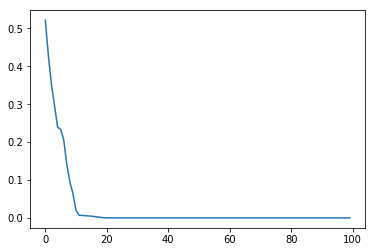

In [79]:
#Setting
m = 10
m_1 = 1
X = uniformSphere(m, 10000)
A = ortho_group.rvs(dim = m)# m orthogonal vectors with dim m, a_1, ..., a_m
A = np.transpose(A)
B = ortho_group.rvs(dim = m)[:m_1]#m_1 orthogonal vectors with dimension m b_1, ..., b_m_1
B = np.transpose(B)
hmm = ddf(X, A,B)
mak = [np.reshape(dd, (m**2,)) for dd in hmm]
M = np.transpose(np.array(mak))
M.shape
U,D,V = np.linalg.svd(M)
plt.plot(list(range(m**2)), D)

In [80]:
U_trunc = U[:,:2*m]
U_unvec = []
for i in range(2*m):
    U_unvec.append(np.reshape(U_trunc[:,i] , (m,m)))
    
    
for i in range(m):
    dist =[]
    for j in range(m+m_1):
        t = np.tensordot(A[:,i], A[:,i], axes=0) - U_unvec[j]
        t2 = -np.tensordot(A[:,i], A[:,i], axes=0) - U_unvec[j]
        d2 = np.linalg.norm(t2)
        d = np.linalg.norm(t)
        
        dist.append(np.min([d,d2]))
    print(dist, "\n")

[0.88886123546288709, 0.79069101170942846, 1.1254639994202948, 1.3000155480017601, 1.4007263526888842, 1.3797240030594984, 1.4017680110600885, 1.4096371509220678, 1.413035033549044, 1.4141223613031835, 1.4140734103121488] 

[1.3952513835986839, 1.4106738843599651, 1.3989139413088165, 1.3955921539773262, 1.4026061771627729, 1.4067355809048407, 1.4002901275185966, 0.052099313340464644, 1.4104919912280756, 1.41026107654653, 1.4121347838079916] 

[1.3743297733778455, 1.4108310172557119, 1.3638498589379191, 1.3574210962119133, 1.3617396092370164, 1.2889555397608372, 0.22119876356090787, 1.406352094876584, 1.4106465925517988, 1.4117684723161268, 1.4138526433080323] 

[1.3570318060578612, 1.4018898830339925, 1.3171322916907273, 1.2852875336340954, 0.53362377999683042, 1.0544667464249082, 1.3320555459588801, 1.406060571546822, 1.4141877764703477, 1.4139110089148825, 1.4128023568398478] 

[1.3669246621816327, 1.4043936657547187, 1.3336654039360054, 1.3088156522085426, 1.0010884969492642, 0.5648

dddf: 0/10000
dddf: 1000/10000
dddf: 2000/10000
dddf: 3000/10000
dddf: 4000/10000
dddf: 5000/10000
dddf: 6000/10000
dddf: 7000/10000
dddf: 8000/10000
dddf: 9000/10000


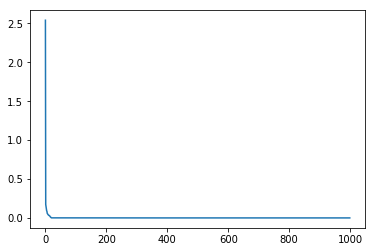

In [81]:
hum  = dddf(X,A,B)
mak = [np.reshape(dd, (m**3,)) for dd in hum]
M = np.transpose(np.array(mak))
M.shape
U,D,V = np.linalg.svd(M)
plt.plot(list(range(m**3)), D)

In [82]:
U_trunc.shape

(100, 20)

In [83]:
U_trunc = U
#U_trunc = U[:,:2*m]
U_unvec = []
"""for i in range(2*m):
    U_unvec.append(np.reshape(U_trunc[:,i] , (m,m)))
"""
    
for i in range(m):
    dist =[]
    for j in range(U_trunc.shape[1]):
        a = tensor3(A[:,i], A[:,i], A[:,i])
        av = np.reshape(a, m**3)
        t =  av - U_trunc[:,j]
        t2 = -av - U_trunc[:,j]
        d2 = np.linalg.norm(t2)
        d = np.linalg.norm(t)
        
        dist.append(np.min([d,d2]))
    print(np.min(dist), "\n")

0.75275048963 

0.48175305012 

0.466024583272 

0.792799157988 

0.746977077391 

0.482245695089 

0.761154865921 

0.792388124698 

0.0664629336958 

0.215602629925 



In [75]:
U_trunc.shape[1]

1000